#Q1 - Outlier Detection and Removal Using Cook's Distance**

## 1.1: Model choice and justification

**Why did you choose this model (Linear vs Ridge vs Lasso)?**

I chose the linear regression model. Since Cook's Distance was mentioned in this question, I immediately opted for linear regression with OLS, as Cook's distance is derived directly from linear regression with OLS. On the other hand, ridge and lasso regressions shrink coefficients which alter leverage and influence measures, which in turn makes Cook's distance less interpretable.

**Why did you choose this library (Statsmodels vs scikit-learn)?**

I chose the statsmodels OLS library for the reason mentioned above. Since the OLS library already has a built in function to directly compute Cook's distance, this library would produce more accurate and precise results than the scikit-learn library.  


## 1.2: Identify outliers, remove them, and export clean CSV

In [69]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

np.set_printoptions(precision=4, suppress=True)

In [ ]:
def fit_ols_diagnostics(X, y):
    """Fit OLS and return (model, diagnostics dataframe).

    Parameters
    ----------
    X : array-like, shape (n,) or (n, p)
        Feature matrix (without intercept column).
    y : array-like, shape (n,)
        Target vector.
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Add intercept column for statsmodels
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()

    infl = OLSInfluence(model)
    diag = pd.DataFrame({
        "y": y,
        "y_hat": model.fittedvalues,
        "residual": model.resid,
        "leverage_hii": infl.hat_matrix_diag,   # diagonal of Hat matrix H
        "cooks_D": infl.cooks_distance[0]
    })
    return model, diag


def plot_line_fit(x, y, model, title=""):
    """Scatter + fitted line for 1D x."""
    x = np.asarray(x).reshape(-1)
    order = np.argsort(x)

    plt.figure(figsize=(7, 4))
    plt.scatter(x, y)
    x_sorted = x[order]

    X_sm = sm.add_constant(x_sorted)
    yhat_sorted = model.predict(X_sm)
    plt.plot(x_sorted, yhat_sorted)

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_curve_fit(x, y, pipeline, title=""):
    """Scatter + fitted curve for scikit-learn pipeline (1D x)."""
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).reshape(-1)

    # Create a smooth grid for plotting
    grid = np.linspace(x.min(), x.max(), 200).reshape(-1, 1)
    yhat = pipeline.predict(grid)

    plt.figure(figsize=(7, 4))
    plt.scatter(x, y)
    plt.plot(grid, yhat)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# === Load dataset ===
DATA_PATH = "usina_with_outliers.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())

target_col = df.columns[-1]  # PE
feature_cols = df.columns[:-1] # AT, V, AP, RH

X = df[feature_cols]
y = df[target_col]

print("Target column:", target_col)
print("Feature columns:", feature_cols)

Shape: (9568, 5)


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Target column: PE
Feature columns: Index(['AT', 'V', 'AP', 'RH'], dtype='object')


In [ ]:
# === Train/Test split (70/30) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (6697, 4) (6697,)
Test : (2871, 4) (2871,)


In [ ]:
X_train_sm = sm.add_constant(X_train.values)   # add intercept
y_train_vec = y_train.values                  # 1D vector

ols_model = sm.OLS(y_train_vec, X_train_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     3109.
Date:                Wed, 28 Jan 2026   Prob (F-statistic):               0.00
Time:                        19:04:17   Log-Likelihood:                -25627.
No. Observations:                6697   AIC:                         5.126e+04
Df Residuals:                    6692   BIC:                         5.130e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.5912     23.258      3.551      0.0

In [ ]:
# Compute Cook's Distance and Cook's Distance threshold
influence = OLSInfluence(ols_model)
cooks_d = influence.cooks_distance[0]
n_train = X_train_sm.shape[0]
threshold = 4/n_train
print(f"Cook's distance heuristic threshold 4/n = {threshold:.6f}")
print()
cooks_df = pd.DataFrame({"CookD": cooks_d}, index = X_train.index)
print(f"5 highest Cook's Distances:")
display(cooks_df.sort_values("CookD", ascending=False).head(5))

# Identify outliers
outlier_cap = cooks_d > threshold
num_outliers = np.sum(outlier_cap)
print()
print(f"Number of outliers: {num_outliers}")

Cook's distance heuristic threshold 4/n = 0.000597

5 highest Cook's Distances:


,CookD
49,1.265702
2538,1.207862
875,1.152221
9241,1.142049
5480,1.105591



Number of outliers: 85


In [ ]:
# Remove outliers from training data
X_train_clean = X_train.loc[~outlier_cap].reset_index(drop=True)
y_train_clean = y_train.loc[~outlier_cap].reset_index(drop=True)

print("Size before cleaning:", X_train.shape[0])
print("Size after cleaning:", X_train_clean.shape[0])

# Create cleaned dataset and export to CSV file
train_df = df.loc[X_train.index.copy()]
train_df_clean = train_df.loc[~outlier_cap].copy()

OUTPUT_FILE = "usina.csv"
train_df_clean.to_csv(OUTPUT_FILE, index = False)

print(f"Cleaned dataset saved to {OUTPUT_FILE}")

Size before cleaning: 6697
Size after cleaning: 6612
Cleaned dataset saved to usina.csv


# Q2 - Train/Test Evaluation Before vs After Outlier Removal

## 2.1 - 2.4: Train Linear, Ridge, and Lasso Regression on "usina_with_outliers.csv" and "usina.csv. Report train/test metrics (MAE, MSE, and R^2). For Ridge and Lasso, use:
## λ ∈ {0.01, 0.1, 1, 10, 100}

In [ ]:
# Helper method for all of question 2
def eval_metrics(y_true, y_pred):
  y_true = np.asarray(y_true).reshape(-1)
  y_pred = np.asarray(y_pred).reshape(-1)
  return {
      "mse": mean_squared_error(y_true, y_pred),
      "mae": mean_absolute_error(y_true, y_pred),
      "r2":  r2_score(y_true, y_pred),
  }

In [72]:
# General evaluation function
def train_test_eval(csv_path, dataset_label):
  df = pd.read_csv(csv_path)

  feature_cols = df.columns[:-1] # AT, V, AP, RH
  target_col = df.columns[-1]    # PE

  X = df[feature_cols]
  y = df[target_col]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size = 0.30, random_state = 42, shuffle = True
  )

  results = []

  # -------- LINEAR REGRESSION ---------
  lin = LinearRegression()
  lin.fit(X_train, y_train)

  results.append({
      "dataset": dataset_label,
      "model": "Linear",
      "lambda": None,
      **{f"train_{k}": v for k,v in eval_metrics(y_train, lin.predict(X_train)).items()},
      **{f"test_{k}": v for k,v in eval_metrics(y_test, lin.predict(X_test)).items()},
  })

  # -------- RIDGE AND LASSO REGRESSION ---------
  lambdas = [0.01, 0.1, 1, 10, 100]

  for cur in lambdas:
    ridge = Ridge(alpha = cur, random_state = 42)
    ridge.fit(X_train, y_train)

    results.append({
        "dataset": dataset_label,
        "model": "Ridge",
        "lambda": cur,
        **{f"train_{k}": v for k,v in eval_metrics(y_train, ridge.predict(X_train)).items()},
        **{f"test_{k}": v for k,v in eval_metrics(y_test, ridge.predict(X_test)).items()},
    })

    lasso = Lasso(alpha=cur, max_iter = 50000, random_state = 42)
    lasso.fit(X_train, y_train)

    results.append({
        "dataset": dataset_label,
        "model": "Lasso",
        "lambda": cur,
        **{f"train_{k}": v for k,v in eval_metrics(y_train, lasso.predict(X_train)).items()},
        **{f"test_{k}": v for k,v in eval_metrics(y_test, lasso.predict(X_test)).items()},
    })

  return pd.DataFrame(results)

In [73]:
outliers_result = train_test_eval(
    "usina_with_outliers.csv",
    "With Outliers"
)

clean_result = train_test_eval(
    "usina.csv",
    "No Outliers"
)

final_results = pd.concat([outliers_result, clean_result], ignore_index = True)
display(final_results.sort_values(["dataset", "model", "lambda", "test_mse", ]))

,dataset,model,lambda,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
13,No Outliers,Lasso,0.01,19.453500,3.571139,0.933362,20.166881,3.618290,0.928319
15,No Outliers,Lasso,0.10,19.454078,3.571544,0.933360,20.176764,3.619849,0.928283
17,No Outliers,Lasso,1.00,19.518117,3.580046,0.933140,20.332249,3.640196,0.927731
19,No Outliers,Lasso,10.00,25.054273,4.040358,0.914176,26.558771,4.181254,0.905599
21,No Outliers,Lasso,100.00,131.895679,9.486983,0.548190,127.911543,9.324437,0.545350
11,No Outliers,Linear,NaN,19.453496,3.571171,0.933362,20.166718,3.618280,0.928319
12,No Outliers,Ridge,0.01,19.453496,3.571171,0.933362,20.166718,3.618280,0.928319
14,No Outliers,Ridge,0.10,19.453496,3.571171,0.933362,20.166724,3.618281,0.928319
16,No Outliers,Ridge,1.00,19.453496,3.571175,0.933362,20.166776,3.618289,0.928319
18,No Outliers,Ridge,10.00,19.453498,3.571211,0.933362,20.167304,3.618377,0.928317


# 2.Discussion

**Do outliers change train error? Test error?**

For both train and test cases, removing outliers significantly increased the amount of error for all models. Specifically, MSE and MAE values increased significantly and R^2 were farther away from 1 when compared to the results from no outliers.

**Which dataset (with outliers vs without outliers) shows better generalization?**

Without outliers. Generalization is measured by how close the test error is to the train error, and for all models (linear, ridge, and lasso), the gap between test and train error is smaller for the dataset without outliers.

**Do Ridge/Lasso appear to help relative to standard linear regression?**

The linear regression results are very close to the results produced by Ridge and Lasso regression when λ = 0.01 for cases with both the outliers included and excluded. Therefore, Rige/Lasso does not provide significant imporvement relative to standard linear regression.

# Q3 - Reliability of Coefficients (Use Outlier-Removed Dataset)

## 3.1: Method Choice and scaling decision

**Chosen model:**

Linear Regression. Since part 3 analyzes the reliability of coefficients and not predicting performance, linear would be more fitting than ridge or lasso. Futhermore, ridge and lasso shrink coefficients which makes it harder to interpret direct reliability.

**Library choice:**

Stasmodels OLS. This is built in with standard errors, t-values, and p-values which will be useful for analyzing reliability of coefficients.

**Scaling:**

Since we want to analyze the direct reliability of coefficients, we should keep DVs and IVs their original scale.

## 3.2: Implentation and results

In [66]:
# Load dataset with no outliers
DATA_PATH = "usina.csv"
df = pd.read_csv(DATA_PATH)

feature_cols = df.columns[:-1] # AT, V, AP, RH
target_col = df.columns[-1] # PE

X = df[feature_cols]
y = df[target_col]

X_sm = sm.add_constant(X)

ols_model = sm.OLS(y, X_sm).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                 2.261e+04
Date:                Wed, 28 Jan 2026   Prob (F-statistic):               0.00
Time:                        21:53:06   Log-Likelihood:                -19229.
No. Observations:                6612   AIC:                         3.847e+04
Df Residuals:                    6607   BIC:                         3.850e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        453.1256     11.444     39.594      0.0

**Identify the most and least reliable coefficients using the output as evidence of reasoning:**

Firstly, a larger absolute value of the t-statistic signifies that the coefficient is likely meaningful and it is not just noise. More specifically, if |t|>2, this often suggests that the coefficient is statistically significant. A higher |t| indicates the coefficient is far from zero relative to its uncertainty, making it more reliable. The absolute value of all coefficients are greater than 2 in this case, meaning all coefficients are statistically significant. However, I can conclude that AT is the most reliable whilst AP is the least reliable with each of their |t| values.

# Q4 - Most Important vs Least Important Features (Use Outlier-Removed Dataset)

## 4.1: Method choice and scaling decision

**Chosen model:**

Linear Regression. The magnitude of the regression coefficeint directly correlates to feature importance. Linear regression is the only model that does not shrink coefficients, which would destort raw magnitudes and make it more difficult to analyze feature importance.

**Library choice:**

scikit-learn. This library makes it easier to directly access .coef, therefore making it simpler to rank feature magnitudes.

**Scaling:**

Scale IVs only. Each IV has different units, so comparing the raw values of each of these coefficients could produce misleading comparisons. Standardizing X will put all features on the same scale so the magnitude of each feature can be compared fairly.

In [71]:
# Scale IVs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin = LinearRegression()
lin.fit(X_scaled, y)

coef_magnitudes = np.abs(lin.coef_)
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "magnitude": lin.coef_,
})

print("Feature importance ranking:")
display(feature_importance)

Feature importance ranking:


,feature,magnitude
0,AT,-14.708987
1,V,-2.922174
2,AP,0.374349
3,RH,-2.265708


## 4.2: Implementation and results

**Identify the most and least important feature using the output as evidence of reasoning:**

The magnitude column above represents the value of the coefficent associated to each feature. Each of these coefficients represent how much the DV changes for a one-unit change in each IV (feature). The absolute value of these magnitudes is equivalent to the strength of the feature's effect. Therefore, a larger absolute value has a stronger impact on the DV. Using this logic, the most important feature is AT and the least important feature is AP.

# Q5 - Regularization Paths (Scaled Data, Outlier-Removed Dataset)

## 5.1-5.4: Implement both ridge and lasso regression. Choosen an appropriate range for λ and generate 100 values in this range. For each λ, fit the model and record coefficient values. Plot the coefficient value vs λ for both models

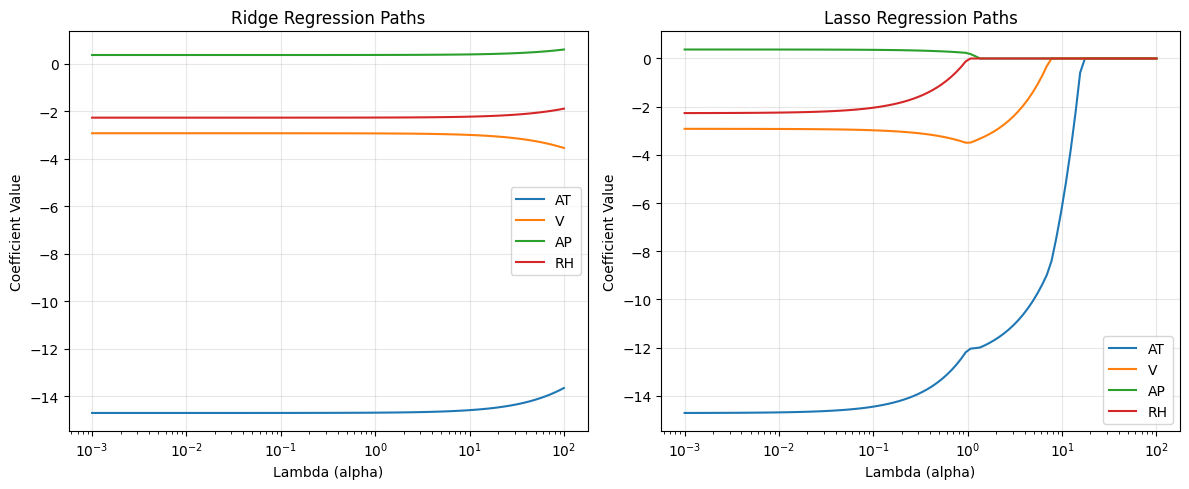

In [74]:
lambdas = np.logspace(-3, 2, 100) # 100 λ values from 0.001 to 100

ridge_coefs = []
lasso_coefs = []

for alpha in lambdas:
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_scaled, y)
  ridge_coefs.append(ridge.coef_)

  lasso = Lasso(alpha = alpha, max_iter = 50000)
  lasso.fit(X_scaled, y)
  lasso_coefs.append(lasso.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

plt.figure(figsize=(12,5))

# Ridge plot
plt.subplot(1,2,1)
for i in range(X_scaled.shape[1]):
  plt.plot(lambdas, ridge_coefs[:, i], label = feature_cols[i])
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Coefficient Value')
plt.title('Ridge Regression Paths')
plt.legend()
plt.grid(True, alpha=0.3)

# Lasso plot
plt.subplot(1,2,2)
for i in range(X_scaled.shape[1]):
  plt.plot(lambdas, lasso_coefs[:, i], label = feature_cols[i])
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regression Paths')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5.Discussion

**What happens to coefficients as λ inreases in Ridge vs Lasso?**

With ridge regression, all coefficient values stay relatively stable as λ increases. Each coefficient stays at a constant value up until λ ≈ 50, then increases/decreases slightly. With lasso regression, all coefficients move towards 0 as λ increases, and eventually reaches exactly zero.

**Which regression is better under multicollinearity in IVs, and why?**

Ridge regression is strong when features are correlated becuase it spreads weight more smoothly across correlated features and thus stabilizes the model. On the other hand, lasso may pick one feature randomly under multicollinearity.

**Which regression is better for feature selection, and why?**

Lasso regression prefers a solution that uses fewer features, and sets coefficients exactly to zero, effectively selecting a subset of features. On the other hand, ridge keeps all features in the model even if they have low signficance/effect.